In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [34]:
# %% [code] {vertical-output: true}
# Cell 1: Setup and Dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from kaggle_datasets import KaggleDatasets

# Configuration
AUTOTUNE = tf.data.experimental.AUTOTUNE
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 10
LAMBDA = 10

# Verify GPU
print("GPU Available:", tf.test.is_gpu_available())
print("TensorFlow Version:", tf.__version__)

GPU Available: True
TensorFlow Version: 2.18.0


I0000 00:00:1746359888.309557      31 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746359888.309818      31 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [31]:
# %% [code] {vertical-output: true}
# Add right after Cell 1 (after GPU verification)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Enabled GPU memory growth")
    except RuntimeError as e:
        print(f"GPU config error: {e}")

GPU config error: Physical devices cannot be modified after being initialized


In [2]:
# %% [code] {vertical-output: true}
# Cell 2: Dataset Discovery
import os

def find_dataset():
    possible_paths = [
        '/kaggle/input/forest-fire-images',
        
    ]
    
    for path in possible_paths:
        if os.path.exists(path):
            print(f"Found dataset at: {path}")
            return path
    raise FileNotFoundError("Could not auto-detect dataset path")

dataset_path = find_dataset()

# Print directory structure
print("\nDataset structure:")
for dirpath, _, filenames in os.walk(dataset_path):
    print(f"{dirpath} ({len(filenames)} files)")

Found dataset at: /kaggle/input/forest-fire-images

Dataset structure:
/kaggle/input/forest-fire-images (0 files)
/kaggle/input/forest-fire-images/Data (0 files)
/kaggle/input/forest-fire-images/Data/Test_Data (0 files)
/kaggle/input/forest-fire-images/Data/Test_Data/Non_Fire (25 files)
/kaggle/input/forest-fire-images/Data/Test_Data/Fire (25 files)
/kaggle/input/forest-fire-images/Data/Train_Data (0 files)
/kaggle/input/forest-fire-images/Data/Train_Data/Non_Fire (2500 files)
/kaggle/input/forest-fire-images/Data/Train_Data/Fire (2500 files)


In [32]:
# %% [code] {vertical-output: true}
# Replace entire Cell 3 with this:
def strict_load_and_preprocess(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])  # Force exact size
    img = (img / 127.5) - 1.0
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])  # Critical shape enforcement
    return img

# Auto-detect fire/non-fire folders
fire_files = []
non_fire_files = []

for root, _, files in os.walk(dataset_path):
    if 'fire' in root.lower() and 'non' not in root.lower():
        fire_files.extend([os.path.join(root, f) for f in files if f.endswith(('.jpg', '.png'))])
    elif 'non' in root.lower() and 'fire' in root.lower():
        non_fire_files.extend([os.path.join(root, f) for f in files if f.endswith(('.jpg', '.png'))])

print(f"Found {len(fire_files)} fire images")
print(f"Found {len(non_fire_files)} non-fire images")

# Create verified datasets
fire_ds = tf.data.Dataset.from_tensor_slices(fire_files)
fire_ds = fire_ds.map(strict_load_and_preprocess, num_parallel_calls=AUTOTUNE)
fire_ds = fire_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

non_fire_ds = tf.data.Dataset.from_tensor_slices(non_fire_files)
non_fire_ds = non_fire_ds.map(strict_load_and_preprocess, num_parallel_calls=AUTOTUNE)
non_fire_ds = non_fire_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Verification
def verify_shapes():
    fire_sample = next(iter(fire_ds.take(1)))
    non_fire_sample = next(iter(non_fire_ds.take(1)))
    print("\nShape Verification:")
    print("Fire batch shape:", fire_sample.shape)
    print("Non-fire batch shape:", non_fire_sample.shape)
    assert fire_sample.shape == non_fire_sample.shape == (BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3)
    
verify_shapes()

Found 2525 fire images
Found 2525 non-fire images

Shape Verification:
Fire batch shape: (1, 256, 256, 3)
Non-fire batch shape: (1, 256, 256, 3)


In [21]:
# ===== BATCH SHAPE VERIFICATION =====
def verify_batch_shapes():
    try:
        fire_batch = next(iter(fire_ds.take(1)))
        non_fire_batch = next(iter(non_fire_ds.take(1)))
        
        print("\nBatch Shape Verification:")
        print("Fire batch shape:", fire_batch.shape)
        print("Non-fire batch shape:", non_fire_batch.shape)
        
        assert fire_batch.shape == non_fire_batch.shape == (BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3), \
               f"Shape mismatch! Expected {(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3)}"
        print("Batch shapes verified successfully!")
    except Exception as e:
        print(f"Verification failed: {str(e)}")
        # Debugging info
        print("\nDebugging Info:")
        sample_img = preprocess_image(load_image(fire_files[0]))
        print("Sample processed image shape:", sample_img.shape)

verify_batch_shapes()
# ===== END VERIFICATION =====


Batch Shape Verification:
Fire batch shape: (1, 256, 256, 3)
Non-fire batch shape: (1, 256, 256, 3)
Batch shapes verified successfully!


In [22]:
# %% [code] {vertical-output: true}
# Cell 4: Model Architectures
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2,
                              padding='same',
                              kernel_initializer=initializer,
                              use_bias=False))
    
    result.add(layers.BatchNormalization())
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    
    result.add(layers.ReLU())
    return result

def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])
    
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                 strides=2,
                                 padding='same',
                                 kernel_initializer=initializer,
                                 activation='tanh')  # (bs, 256, 256, 3)
    
    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    
    x = inp
    
    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)
    
    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)
    
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)
    
    return tf.keras.Model(inputs=inp, outputs=last)

In [23]:
# %% [code] {vertical-output: true}
# Cell 5: Loss Functions and Models
# Loss functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Initialize models
generator_g = build_generator()
generator_f = build_generator()
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [24]:
# %% [code] {vertical-output: true}
# Debugging Cell (Run before training)
print("Verifying dataset pipeline...")

# 1. Check if datasets are empty
print(f"Fire dataset size: {len(fire_files)}")
print(f"Non-fire dataset size: {len(non_fire_files)}")

if len(fire_files) == 0 or len(non_fire_files) == 0:
    raise ValueError("No images found in one or both datasets!")

# 2. Verify first few files
print("\nSample fire files:")
for f in fire_files[:3]:
    print(f" - {f} (exists: {os.path.exists(f)})")
    
print("\nSample non-fire files:")
for f in non_fire_files[:3]:
    print(f" - {f} (exists: {os.path.exists(f)})")

# 3. Test loading a single image
def test_load_image(file_path):
    try:
        img = load_image(file_path)
        print(f"\nSuccessfully loaded: {file_path}")
        print(f"Shape: {img.shape}, Dtype: {img.dtype}, Min: {tf.reduce_min(img):.1f}, Max: {tf.reduce_max(img):.1f}")
        return True
    except Exception as e:
        print(f"\nFailed to load {file_path}: {str(e)}")
        return False

print("\nTesting image loading...")
test_load_image(fire_files[0])
test_load_image(non_fire_files[0])

# 4. Verify dataset pipeline
try:
    test_batch = next(iter(non_fire_ds.take(1)))
    print("\nDataset pipeline test successful!")
    print(f"Batch shape: {test_batch.shape}")
except Exception as e:
    print(f"\nDataset pipeline failed: {str(e)}")
    print("\nTrying alternative approach...")
    
    # Alternative dataset creation
    non_fire_ds = tf.data.Dataset.from_tensor_slices(non_fire_files)
    non_fire_ds = non_fire_ds.map(lambda x: tf.py_function(
        lambda y: preprocess_image(load_image(y)), [x], tf.float32),
        num_parallel_calls=AUTOTUNE)
    non_fire_ds = non_fire_ds.batch(1)
    
    fire_ds = tf.data.Dataset.from_tensor_slices(fire_files)
    fire_ds = fire_ds.map(lambda x: tf.py_function(
        lambda y: preprocess_image(load_image(y)), [x], tf.float32),
        num_parallel_calls=AUTOTUNE)
    fire_ds = fire_ds.batch(1)
    
    try:
        test_batch = next(iter(non_fire_ds.take(1)))
        print("Alternative pipeline worked!")
    except Exception as e:
        print("Still failing. Please check your dataset.")
        raise e

Verifying dataset pipeline...
Fire dataset size: 2525
Non-fire dataset size: 2525

Sample fire files:
 - /kaggle/input/forest-fire-images/Data/Test_Data/Fire/F_19.jpg (exists: True)
 - /kaggle/input/forest-fire-images/Data/Test_Data/Fire/F_10.jpg (exists: True)
 - /kaggle/input/forest-fire-images/Data/Test_Data/Fire/F_2.jpg (exists: True)

Sample non-fire files:
 - /kaggle/input/forest-fire-images/Data/Test_Data/Non_Fire/NF_19.jpg (exists: True)
 - /kaggle/input/forest-fire-images/Data/Test_Data/Non_Fire/NF_23.jpg (exists: True)
 - /kaggle/input/forest-fire-images/Data/Test_Data/Non_Fire/NF_11.jpg (exists: True)

Testing image loading...

Successfully loaded: /kaggle/input/forest-fire-images/Data/Test_Data/Fire/F_19.jpg
Shape: (1067, 1600, 3), Dtype: <dtype: 'float32'>, Min: 0.0, Max: 255.0

Successfully loaded: /kaggle/input/forest-fire-images/Data/Test_Data/Non_Fire/NF_19.jpg
Shape: (800, 1400, 3), Dtype: <dtype: 'float32'>, Min: 0.0, Max: 255.0

Dataset pipeline test successful!
Bat

In [26]:
# %% [code] {vertical-output: true}
# Cell 6: Training Setup
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(
    generator_g=generator_g,
    generator_f=generator_f,
    discriminator_x=discriminator_x,
    discriminator_y=discriminator_y,
    generator_g_optimizer=generator_g_optimizer,
    generator_f_optimizer=generator_f_optimizer,
    discriminator_x_optimizer=discriminator_x_optimizer,
    discriminator_y_optimizer=discriminator_y_optimizer
)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Load latest checkpoint if exists
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

# Visualization function
def generate_images(model, test_input):
    prediction = model(test_input)
    
    plt.figure(figsize=(12, 12))
    
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [27]:
# %% [code] {vertical-output: true}
# Cell 7: Training Loop
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # Identity mapping
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        # Discriminator output
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # Generator losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        # Cycle consistency losses
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    # Calculate gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply gradients
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))
    
    return gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss

Epoch 1, Step 0: GenLoss=0.8564, DiscLoss=0.9722
Epoch 1, Step 10: GenLoss=0.9323, DiscLoss=0.6840
Epoch 1, Step 20: GenLoss=0.4666, DiscLoss=1.3162
Epoch 1, Step 30: GenLoss=1.0002, DiscLoss=0.3601
Skipping step 31: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is empty.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 
Skipping step 33: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is empty.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 
Skipping step 35: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is empty.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 
Skipping step 40: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is empty.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 
S

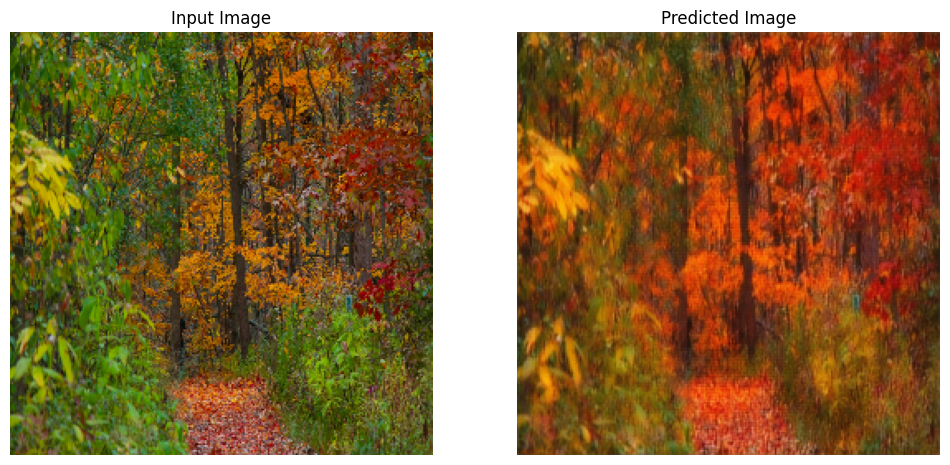

Epoch 2, Step 0: GenLoss=0.9050, DiscLoss=0.6239
Epoch 2, Step 10: GenLoss=1.3460, DiscLoss=0.5068
Epoch 2, Step 20: GenLoss=0.5381, DiscLoss=1.1847
Epoch 2, Step 30: GenLoss=1.0753, DiscLoss=0.3589
Skipping step 31: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is empty.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 
Skipping step 33: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is empty.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 
Skipping step 35: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is empty.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 
Skipping step 40: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is empty.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 
S

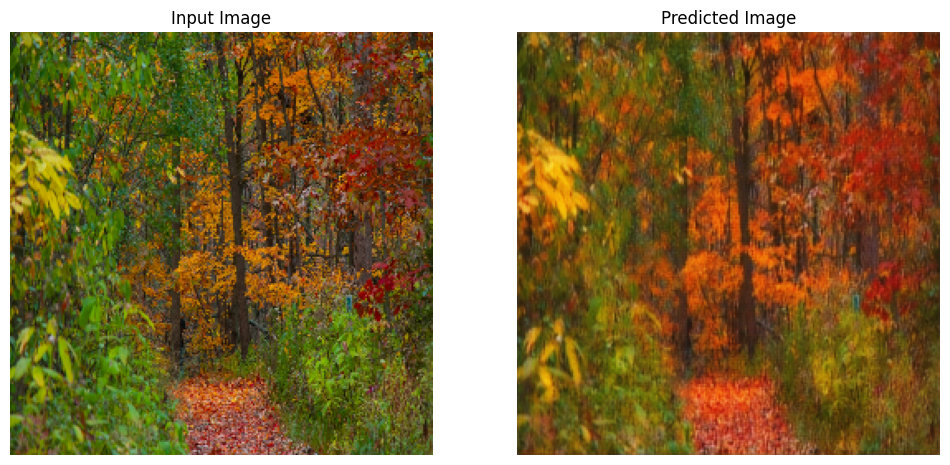

Epoch 3, Step 0: GenLoss=1.0353, DiscLoss=0.5096
Epoch 3, Step 10: GenLoss=1.2977, DiscLoss=0.4764
Epoch 3, Step 20: GenLoss=0.5556, DiscLoss=1.2152
Epoch 3, Step 30: GenLoss=1.1394, DiscLoss=0.3034
Skipping step 31: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is empty.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 
Skipping step 33: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is empty.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 
Skipping step 35: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is empty.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 
Skipping step 40: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is empty.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 
S

In [35]:
# %% [code] {vertical-output: true}
# Updated configuration (put this in your first cell)
EPOCHS = 10  # Reduced from 50 but still meaningful
STEPS_PER_EPOCH = 100  # Process only 100 batches per epoch
EARLY_STOP_PATIENCE = 2  # Stop if no improvement

# Add this to your training loop (modified version):
best_loss = float('inf')
patience_counter = 0

for epoch in range(EPOCHS):
    start = time.time()
    epoch_gen_loss = 0
    epoch_disc_loss = 0
    
    fire_iter = iter(fire_ds)
    non_fire_iter = iter(non_fire_ds)
    
    for step in range(STEPS_PER_EPOCH):
        try:
            image_x = next(non_fire_iter)
            image_y = next(fire_iter)
            
            gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y)
            
            epoch_gen_loss += (gen_g_loss + gen_f_loss)/2
            epoch_disc_loss += (disc_x_loss + disc_y_loss)/2
            
            if step % 10 == 0:
                print(f'Epoch {epoch+1}, Step {step}: GenLoss={(gen_g_loss+gen_f_loss)/2:.4f}, DiscLoss={(disc_x_loss+disc_y_loss)/2:.4f}')
                
        except Exception as e:
            print(f"Skipping step {step}: {str(e)}")
            continue
    
    # Early stopping check
    avg_gen_loss = epoch_gen_loss/STEPS_PER_EPOCH
    if avg_gen_loss < best_loss:
        best_loss = avg_gen_loss
        patience_counter = 0
        # Save model checkpoint
        generator_g.save('/kaggle/working/best_generator.h5')
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    print(f'Epoch {epoch+1} completed. GenLoss={avg_gen_loss:.4f}, Time: {time.time()-start:.2f}s')
    generate_images(generator_g, next(iter(non_fire_ds.take(1))))

Evaluation Metrics:
PSNR: 9.3114
SSIM: 0.0481
MSE: 0.4687


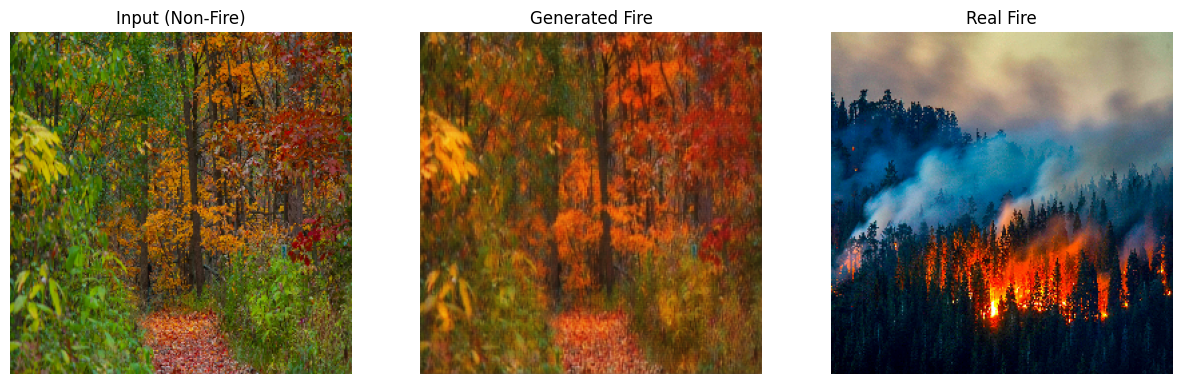

In [36]:
# %% [code] {vertical-output: true}
# Cell 9: Evaluation Metrics
def calculate_psnr(real, generated):
    return tf.image.psnr(real, generated, max_val=2.0).numpy().mean()

def calculate_ssim(real, generated):
    return tf.image.ssim(real, generated, max_val=2.0).numpy().mean()

def calculate_mse(real, generated):
    return tf.keras.losses.MeanSquaredError()(real, generated).numpy()

# Test on sample images
test_non_fire = next(iter(non_fire_ds.take(5)))
test_fire = next(iter(fire_ds.take(5)))

generated_fire = generator_g(test_non_fire, training=False)

print("Evaluation Metrics:")
print(f"PSNR: {calculate_psnr(test_fire, generated_fire):.4f}")
print(f"SSIM: {calculate_ssim(test_fire, generated_fire):.4f}")
print(f"MSE: {calculate_mse(test_fire, generated_fire):.4f}")

# Visual comparison
plt.figure(figsize=(15, 15))
display_list = [test_non_fire[0], generated_fire[0], test_fire[0]]
title = ['Input (Non-Fire)', 'Generated Fire', 'Real Fire']

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
plt.show()

In [37]:
# %% [code] {vertical-output: true}
# Cell 10: Save Models
generator_g.save('/kaggle/working/fire_generator.h5')
generator_f.save('/kaggle/working/non_fire_generator.h5')
discriminator_x.save('/kaggle/working/non_fire_discriminator.h5')
discriminator_y.save('/kaggle/working/fire_discriminator.h5')

print("Models saved successfully in /kaggle/working/ directory")

Models saved successfully in /kaggle/working/ directory
